In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import random

import numpy as np
from tifffile import TiffFile
import matplotlib.pyplot as plt
from tqdm import tqdm

from framework.dataset import LandCoverData as LCD

Note: you might have to change your path to the unzipped dataset. Mine is at `~/challenge-ens/data/dataset_UNZIPPED`. The dataset folder should be like this :
```
dataset_UNZIPPED
├── test
│   └── images
│       ├── 10087.tif
│       ├── 10088.tif
│       ├── 10089.tif
│       ├── 10090.tif
        ... (5043 files)
└── train
    ├── images
    │   ├── 10000.tif
    │   ├── 10001.tif
    │   ├── 10002.tif
    │   ├── 10003.tif
        ... (18491 files)
    └── masks
        ├── 10000.tif
        ├── 10001.tif
        ├── 10002.tif
        ├── 10003.tif
        ... (18491 files)
```

In [2]:
DATA_FOLDER_STR = '~/Documents/LandCover_Preligens/'
DATA_FOLDER = Path(DATA_FOLDER_STR).expanduser()
# path to the unzipped dataset: contains directories train/ and test/
DATASET_FOLDER = DATA_FOLDER/'dataset'

# get all train images and masks
train_images_paths = sorted(list(DATASET_FOLDER.glob('train/images/*.tif')))
train_masks_paths = sorted(list(DATASET_FOLDER.glob('train/masks/*.tif')))
# get all test images
test_images_paths = sorted(list(DATASET_FOLDER.glob('test/images/*.tif')))

## Visualize data points

In [3]:
def show_image(image, display_min=50, display_max=400, ax=None):
    """Show an image.
    Args:
        image (numpy.array[uint16]): thtste image. If the image is 16-bit, apply bytescaling to convert to 8-bit
    """
    if image.dtype == np.uint16:
        iscale = display_max - display_min
        scale = 255 / iscale
        byte_im = (image) * scale
        byte_im = (byte_im.clip(0, 255) + 0.5).astype(np.uint8)
        image = byte_im
    # show image
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    ax.axis("off")
    im = ax.imshow(image)
    return im

def show_mask(mask, classes_colorpalette, classes=None, add_legend=True, ax=None):
    """Show a a semantic segmentation mask.
    Args:
       mask (numpy.array[uint8]): the mask in 8-bit
       classes_colorpalette (dict[int, tuple]): dict mapping class index to an RGB color in [0, 1]
       classes (list[str], optional): list of class labels
       add_legend
    """
    show_mask = np.empty((*mask.shape, 3))
    for c, color in classes_colorpalette.items():
        show_mask[mask == c, :] = color
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    ax.axis("off")
    im = ax.imshow(show_mask)
    if add_legend:
        # show legend mapping pixel colors to class names
        import matplotlib.patches as mpatches
        handles = []
        for c, color in classes_colorpalette.items():
            handles.append(mpatches.Patch(color=color, label=classes[c]))
        ax.legend(handles=handles)
    return im

### Plot a few (image, mask) pairs from the training set
Note: The satellite images are in 16-bit format and need to be converted to 8-bit format ("bytescaling") for plotting with matplotlib. The bytescaling creates colors not faithful to the original picture. Below we use parameters for bytescaling (namely `display_min` and `display_max` that render the images as dark and blueish.

### Plot a few images from the training set

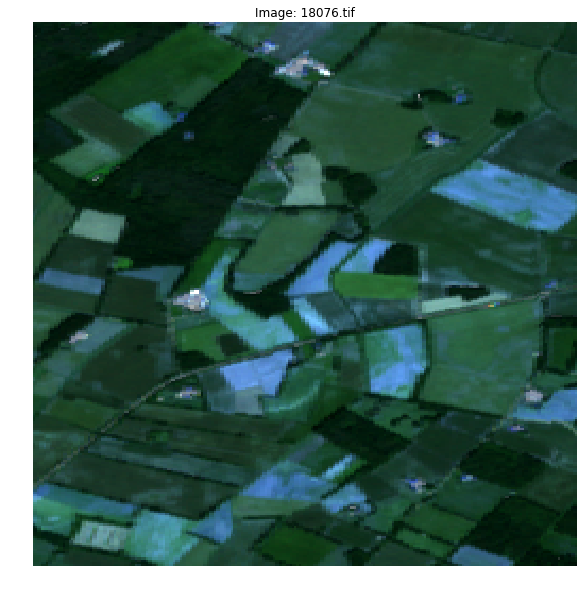

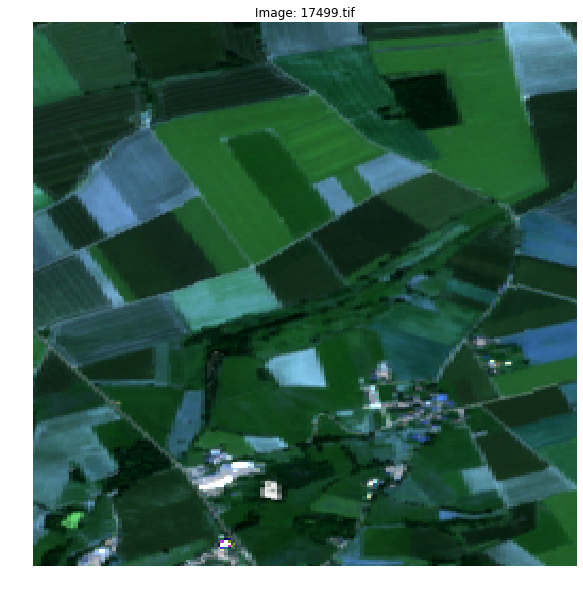

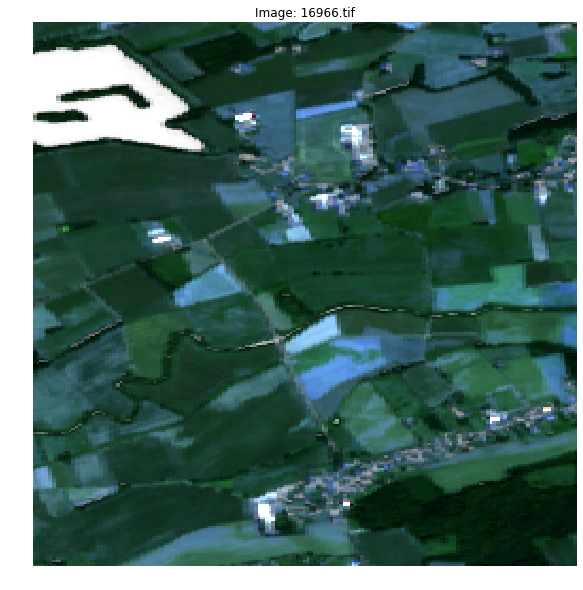

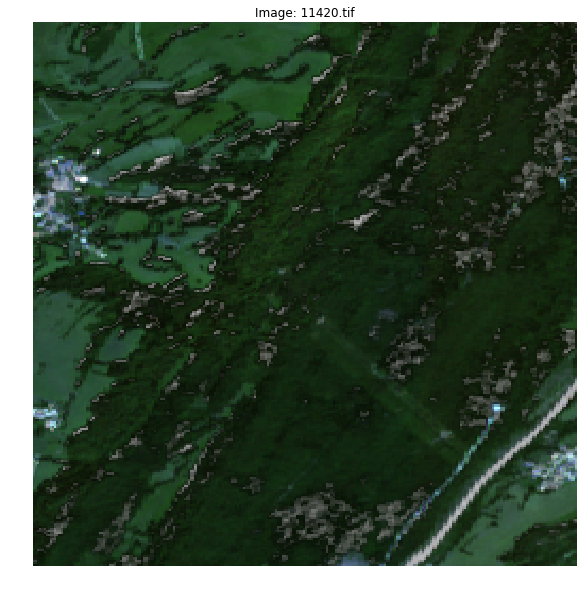

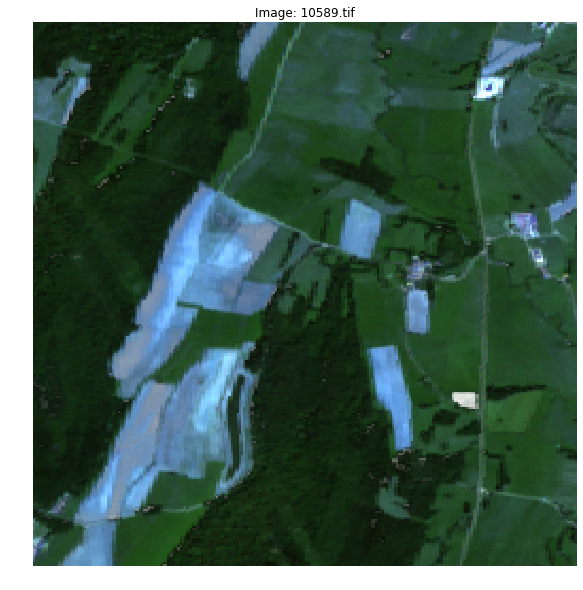

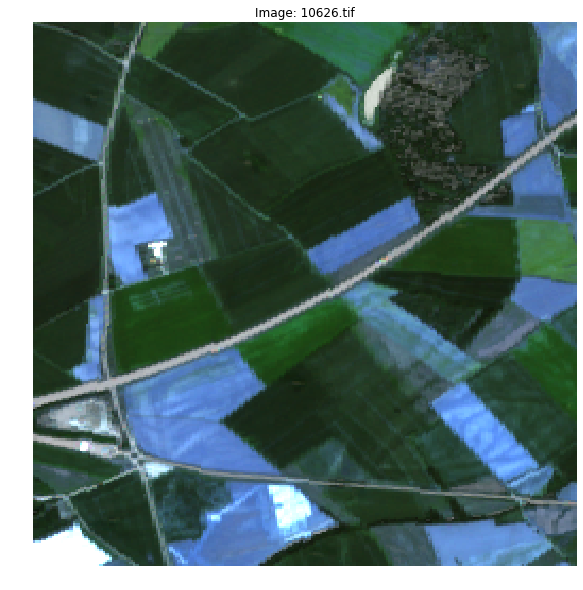

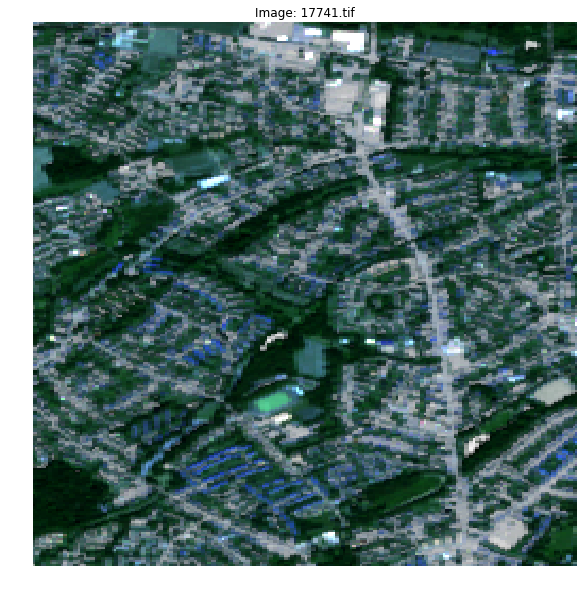

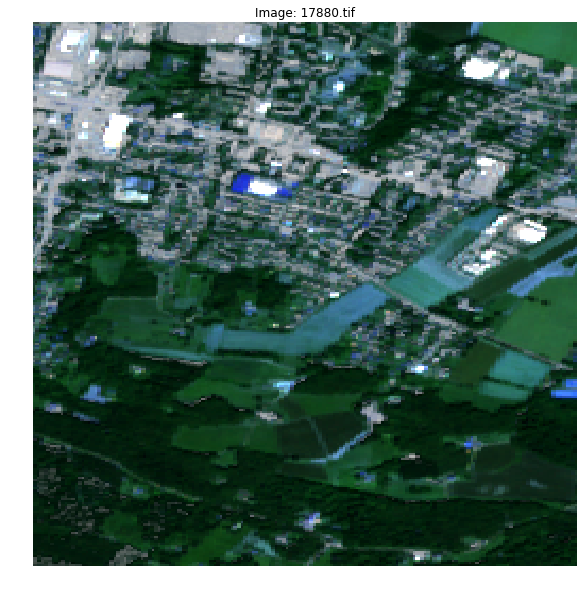

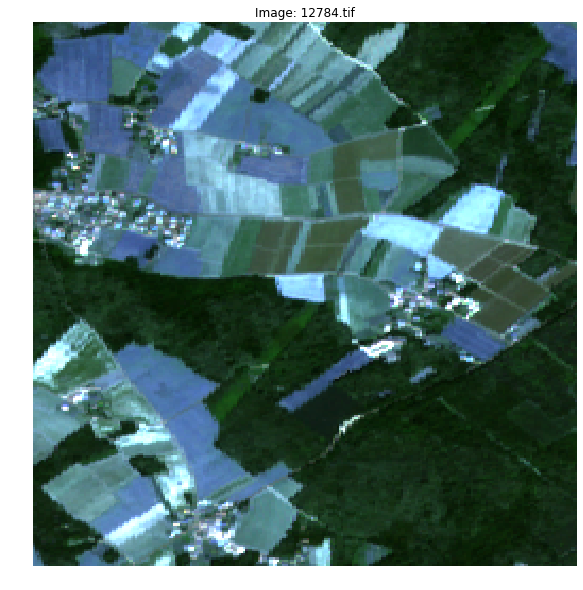

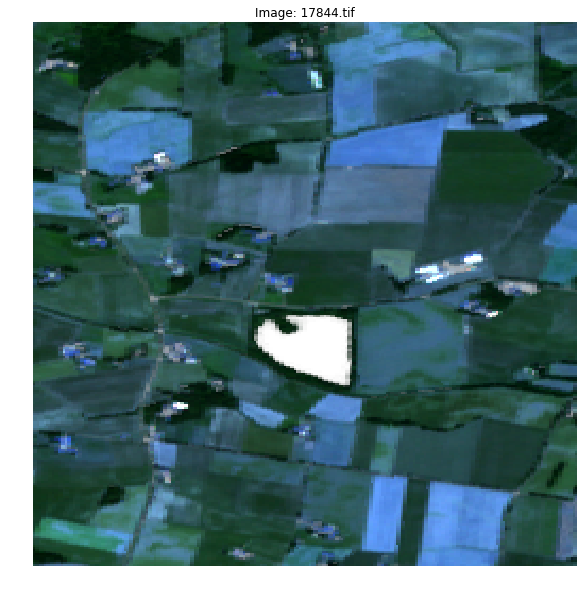

In [4]:
# Show 10 random images from the testing set
for idx in random.sample(range(len(test_images_paths)), 10):
    image_path = test_images_paths[idx]
    
    with TiffFile(image_path) as tif:
        arr = tif.asarray()        
    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(arr, display_min=0, display_max=2200, ax=ax)
    
    ax.set_title(f'Image: {image_path.name}')
    #fig.tight_layout()

## Plot total class distribution in the training set

In [5]:
# Compute total class distribution in train
def compute_class_counts(masks_paths, n_classes=10):
    """Return the cumulated class counts for all masks in the training set.
    Args:
        masks_paths (list[path-like]): paths to all masks 
    """
    cumcount = np.zeros((n_classes,), dtype=np.int64)
    for path in tqdm(train_masks_paths):
        with TiffFile(path) as tif:
            arr = tif.asarray()
            count = np.bincount(arr.ravel(), minlength=10)
            # hist, _ = np.histogram(arr, bins=n_classes, range=(0, 10)) # @todo: use bincount
            cumcount += count
    return cumcount
    
train_class_counts = compute_class_counts(train_masks_paths, n_classes=LCD.N_CLASSES)
# this should be equal to LandCoverData.TRAIN_CLASS_COUNTS
assert (train_class_counts == LCD.TRAIN_CLASS_COUNTS).all()
# normalize to get a distribution
train_class_dist = train_class_counts / train_class_counts.sum()

100%|██████████| 18491/18491 [03:25<00:00, 89.81it/s]


In [6]:
def plot_class_distributions(class_counts, classes=None, class_colors=None):
    """Plot the proportion of the number of pixels for every class
    Args:
        class_counts (numpy.array): the raw class counts of shape (N_CLASSES,)
        classes (list[str], optional): list of class labels
        class_colors (numpy.array, optional): array of colors of shape (N_CLASSES, 3) in [0, 1]
    """
    rc_dict = { # font params for display
        'axes.titlesize': 19,
        'axes.labelsize': 16,
        'lines.linewidth': 2,
        'lines.markersize': 8,
        'font.size': 12,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12
    }
    with plt.style.context(['seaborn', rc_dict]):
        class_dist = class_counts / class_counts.sum()
        fig, ax = plt.subplots(figsize=(12, 8))
        rects = ax.bar(range(len(class_dist)), class_dist, color=class_colors)
        ax.set_xticks(range(len(class_dist)))
        if classes is not None:
            ax.set_xticklabels(classes, rotation=90)
       
        for i, v in enumerate(class_counts):
            ax.text(i, class_dist[i] + 0.005, "{:.2e}".format(v))
        ax.set_xlabel("Classes")
        ax.set_ylabel("Proportion of the number of pixels")
        ax.set_title("Training set")

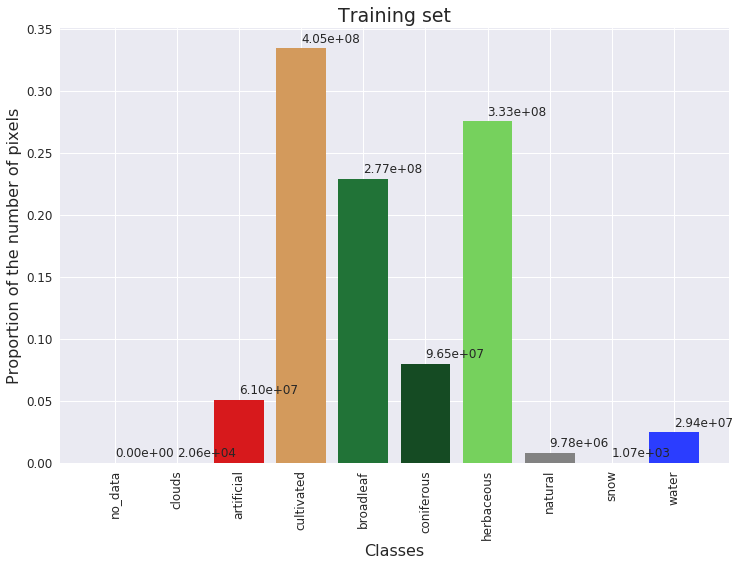

In [7]:
plot_class_distributions(
    train_class_counts,
    classes=list(LCD.CLASSES),
    class_colors = np.asarray(list(LCD.CLASSES_COLORPALETTE.values()))/255.
)